In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dashboard libraries
from jupyter_dash import JupyterDash
from dash import dcc, html
import plotly.graph_objs as go


In [2]:
df_csv1 = pd.read_csv("/Users/ogulcan/Desktop/Projects/archive-2/df_weekly_MI-006_enriched.csv")
df_csv2 = pd.read_csv("/Users/ogulcan/Desktop/Projects/archive-2/FMCG_2022_2024.csv")
df_csv3 = pd.read_csv("/Users/ogulcan/Desktop/Projects/archive-2/weekly_df_final_for_modeling.csv")

In [3]:
df_csv2.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


In [4]:
print(df_csv2.head())
print(df_csv2.info())
df_csv2['date'] = pd.to_datetime(df_csv2['date'])

print(df_csv2.isnull().sum())

         date     sku     brand    segment category   channel      region  \
0  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk    Retail  PL-Central   
1  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk    Retail    PL-North   
2  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk    Retail    PL-South   
3  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk  Discount  PL-Central   
4  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk  Discount    PL-North   

   pack_type  price_unit  promotion_flag  delivery_days  stock_available  \
0  Multipack        2.38               0              1              141   
1     Single        1.55               1              3                0   
2     Carton        4.00               0              5              118   
3     Single        5.16               0              2               81   
4     Single        7.66               0              4              148   

   delivered_qty  units_sold  
0            128           9  
1            129  

date
2022-01-23     449
2022-01-30    1324
2022-02-06    1496
2022-02-13    1435
2022-02-20    1367
2022-02-27    1313
2022-03-06    2653
2022-03-13    2630
2022-03-20    4009
2022-03-27    4285
Freq: W-SUN, Name: units_sold, dtype: int64


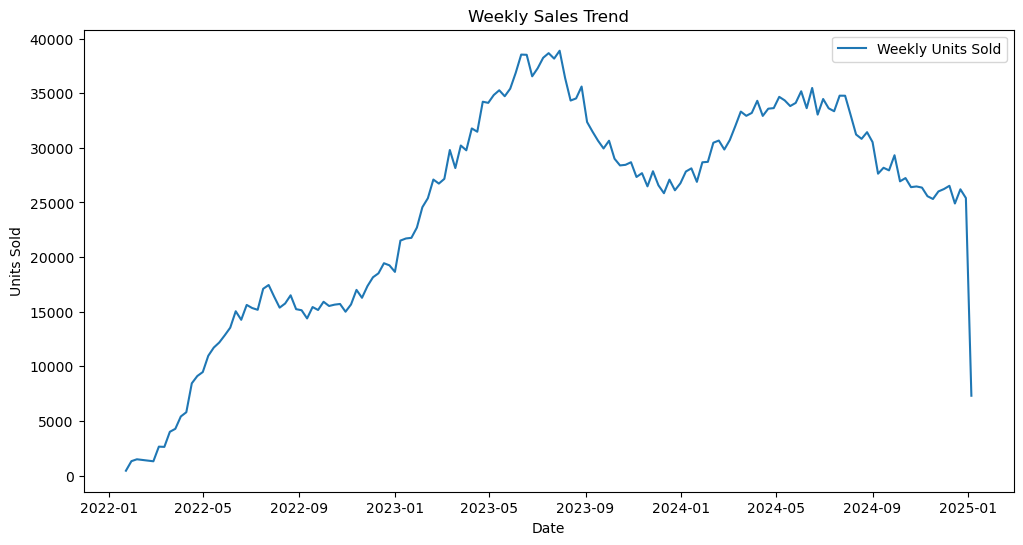

In [5]:
# Date sütununu datetime formatında kontrol et
df_csv2['date'] = pd.to_datetime(df_csv2['date'])
# Tarihi index olarak ayarla
df_csv2.set_index('date', inplace=True)

# Daily Sales: Günlük toplam satışları hesaplıyoruz
# Eğer aynı gün birden fazla SKU veya kanal kaydı varsa, bunları topluyoruz.
# Daily Sales: We calculate the total daily sales.
# If there are multiple SKU or channel records on the same day, we sum them.
daily_sales = df_csv2['units_sold'].resample('D').sum()

# Haftalık toplam satışları hesaplıyoruz
# Weekly Sales: Haftalık trendleri daha net görebilmek ve mevsimsel değişiklikleri analiz etmek için kullanılır
# Weekly Sales: We calculate the total weekly sales.
# Used to better observe weekly trends and analyze seasonal changes
weekly_sales = df_csv2['units_sold'].resample('W').sum()

# İlk 10 haftayı kontrol et
# Check first 10 weeks
print(weekly_sales.head(10))

# Haftalık satış trendini çiziyoruz
# We plot the weekly sales trend
plt.figure(figsize=(12,6))
plt.plot(weekly_sales, label='Weekly Units Sold')
plt.title('Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

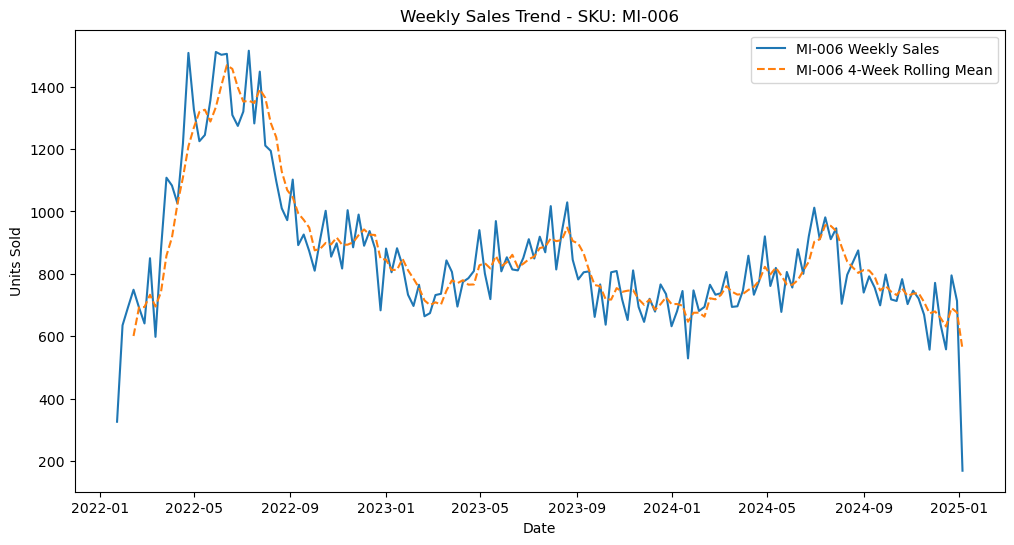

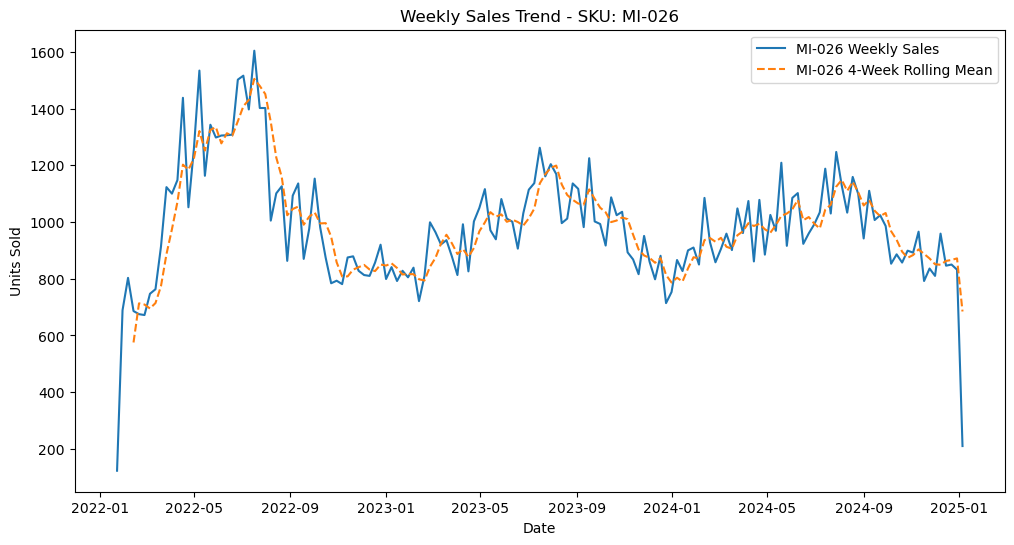

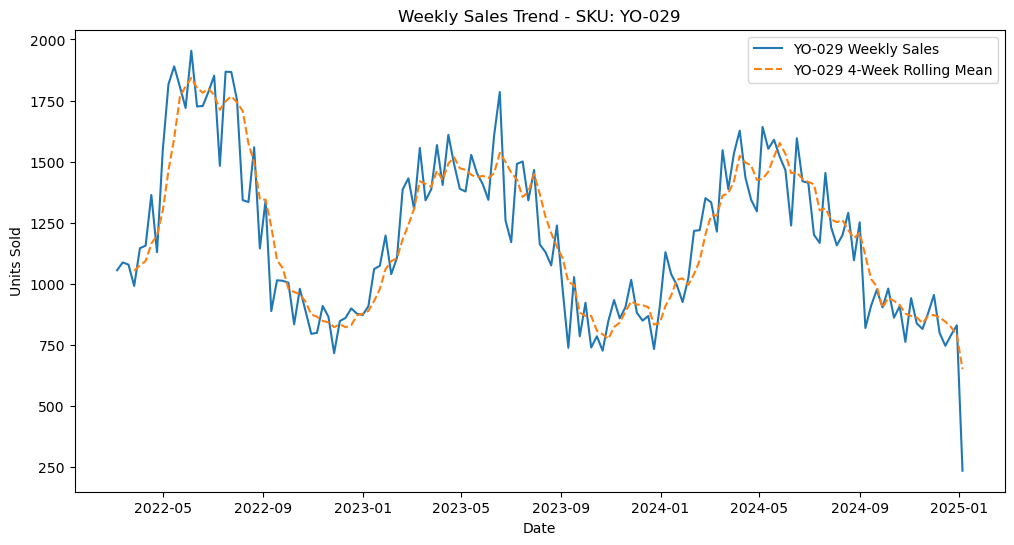

In [6]:
# SKU bazlı haftalık satış trendi
# Weekly sales per SKU
sku_weekly = df_csv2.groupby('sku')['units_sold'].resample('W').sum()

# 4 haftalık hareketli ortalama
# 4-week rolling average for smoothing trends
sku_weekly_rolling = (
    sku_weekly.groupby('sku')
              .rolling(4)
              .mean()
              .reset_index(level=0, drop=True)
)

# Örnek görselleştirme: İlk 3 SKU için
# Example visualization: First 3 SKUs
for sku_id in df_csv2['sku'].unique()[:3]:
    plt.figure(figsize=(12,6))
    plt.plot(sku_weekly.loc[sku_id], label=f'{sku_id} Weekly Sales')
    plt.plot(sku_weekly_rolling.loc[sku_id], label=f'{sku_id} 4-Week Rolling Mean', linestyle='--')
    plt.title(f'Weekly Sales Trend - SKU: {sku_id}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

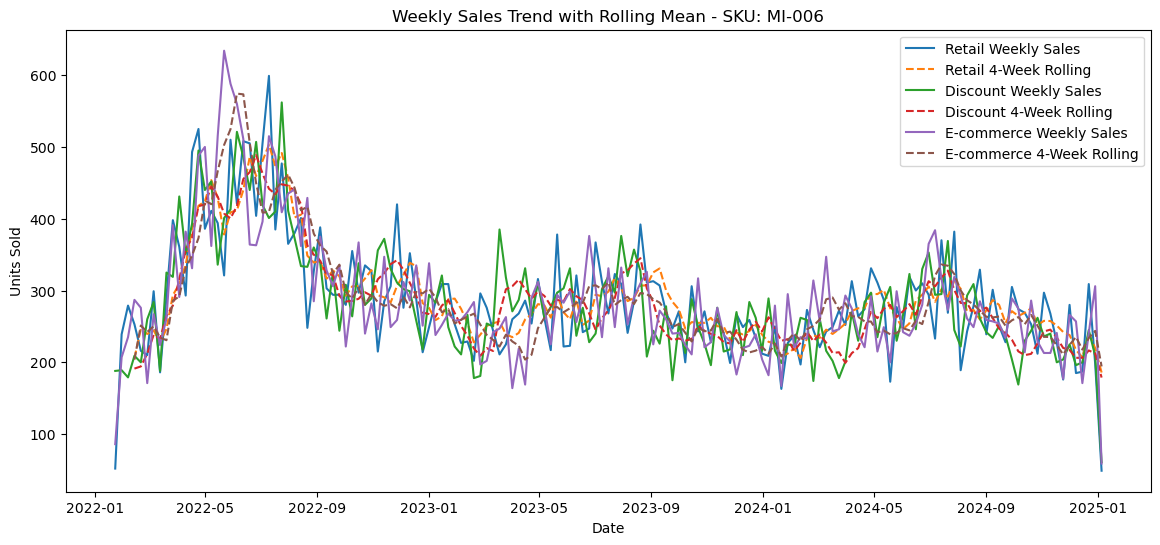

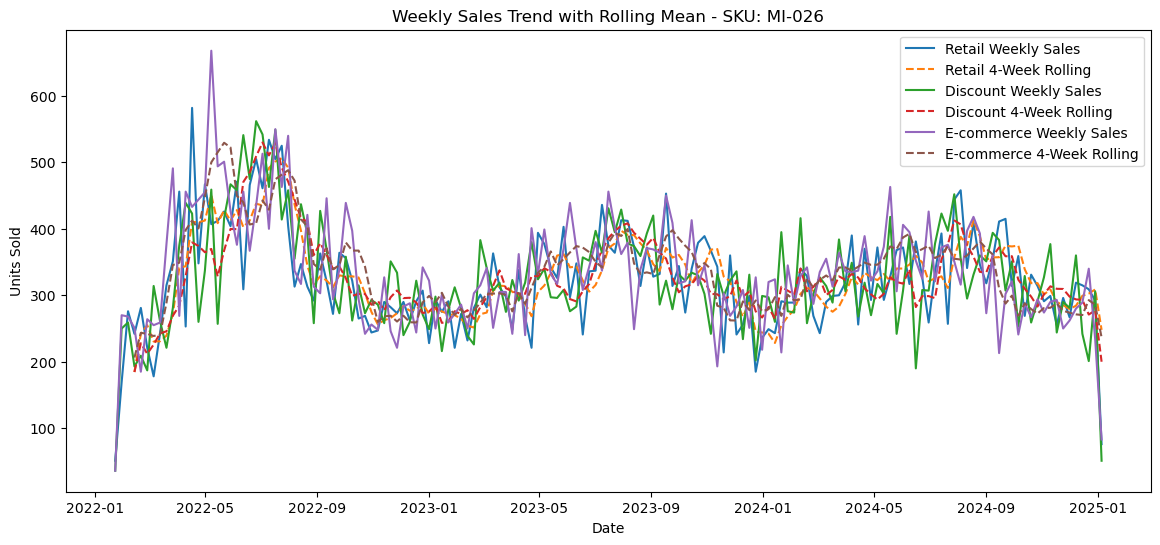

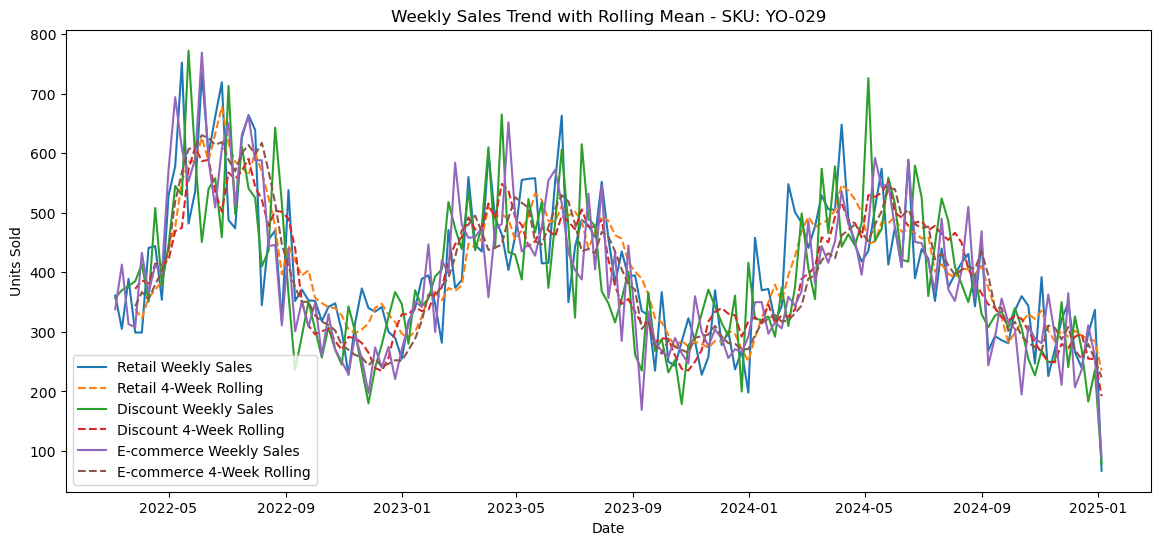

In [7]:
# Örnek: İlk 3 SKU ve tüm kanallar için grafik
# Example: First 3 SKUs and all channels
skus_to_plot = df_csv2['sku'].unique()[:3]
channels = df_csv2['channel'].unique()

for sku_id in skus_to_plot:
    plt.figure(figsize=(14,6))
    
    for channel in channels:
        # SKU ve channel bazlı veri filtreleme
        df_filtered = df_csv2[(df_csv2['sku']==sku_id) & (df_csv2['channel']==channel)].copy()
        
        # Tarih indexi garanti altına al
        if 'date' in df_filtered.columns:
            df_filtered['date'] = pd.to_datetime(df_filtered['date'])
            df_filtered.set_index('date', inplace=True)
        
        # Haftalık toplam satış
        weekly_data = df_filtered['units_sold'].resample('W').sum()
        
        # 4 haftalık rolling mean
        rolling = weekly_data.rolling(4).mean()
        
        # Orijinal trend çizgisi
        plt.plot(weekly_data, label=f'{channel} Weekly Sales')
        
        # Rolling mean çizgisi (kesikli)
        plt.plot(rolling, linestyle='--', label=f'{channel} 4-Week Rolling')
    
    plt.title(f'Weekly Sales Trend with Rolling Mean - SKU: {sku_id}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

In [8]:
import dash
from dash import dcc, html
import plotly.graph_objs as go

# Dash uygulaması başlat
app = dash.Dash(__name__)

# SKU ve Channel seçenekleri
sku_options = df_csv2['sku'].unique()
channel_options = df_csv2['channel'].unique()

# Layout
app.layout = html.Div([
    html.H1("Weekly Sales Dashboard"),

    html.Label("Select SKU:"),
    dcc.Dropdown(
        id='sku-dropdown',
        options=[{'label': i, 'value': i} for i in sku_options],
        value=sku_options[0]
    ),

    html.Label("Select Channels:"),
    dcc.Dropdown(
        id='channel-dropdown',
        options=[{'label': i, 'value': i} for i in channel_options],
        value=list(channel_options),
        multi=True
    ),

    dcc.Graph(id='sales-graph')
])

# Callback
@app.callback(
    dash.dependencies.Output('sales-graph', 'figure'),
    [dash.dependencies.Input('sku-dropdown', 'value'),
     dash.dependencies.Input('channel-dropdown', 'value')]
)
def update_graph(selected_sku, selected_channels):
    fig = go.Figure()

    if not selected_channels:
        return fig  

    for channel in selected_channels:
        df_filtered = df_csv2[(df_csv2['sku']==selected_sku) & (df_csv2['channel']==channel)].copy()
        
        if df_filtered.empty:
            continue

        # Tarih indexi kontrolü
        if 'date' in df_filtered.columns:
            df_filtered['date'] = pd.to_datetime(df_filtered['date'])
            df_filtered = df_filtered.set_index('date')
        elif df_filtered.index.name != 'date':
            continue  # Hata almamak için atla
        
        # Haftalık satış ve rolling mean
        weekly = df_filtered['units_sold'].resample('W').sum()
        rolling = weekly.rolling(4).mean()

        # Orijinal ve rolling trend
        fig.add_trace(go.Scatter(x=weekly.index, y=weekly, mode='lines', name=f'{channel} Weekly'))
        fig.add_trace(go.Scatter(x=rolling.index, y=rolling, mode='lines', name=f'{channel} Rolling 4W', line=dict(dash='dash')))

    fig.update_layout(
        title=f'Weekly Sales and Rolling Mean - {selected_sku}',
        xaxis_title='Date',
        yaxis_title='Units Sold'
    )
    return fig

# Dash çalıştırma (Jupyter uyumlu)
if __name__ == '__main__':
    app.run(debug=True)